<div align="center">

# MScFE 622 STOCHASTIC MODELING

## Group Work Project #2: Regime Switching Time Series Models

### Group 10341

</div>


*[Link to Instruction](https://drive.google.com/file/d/18PuscCTRxA6h1IyzOBdl-YsnaUrMdPag/view?usp=share_link)*

# Step 1

## Member A

- I will choose data from  either of the following
    - Volatility Index
    - WTI Crude Oil
- which both show dramatic regime changes with clear economic interprations for this exercise
- We will source the data using data pipeline as show below

In [ ]:
!pip install fredapi
!pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
import seaborn as sns
from fredapi import Fred

api_key = '89c6b8af99f6af0c97f0b4bc9e315e7b'

# Initialize FRED API Connection
def initialize_fred(api_key=None):
    try:
        if not api_key:
            fred = None
            print("Provide a FRED API Key to proceed")
        else:
            fred = Fred(api_key=api_key)
        return fred

    except Exception as e:
        print(f"FRED API initialization failed: {str(e)}")

def fetch_vix_data(api_key, start_date="2019-01-01", end_date="2022-09-30"):
    """
    We will use multiple  sources to ensure data availability
    Our primary source will be FRED and Fallback: Yahoo Finance
    """
    try:
        fred = initialize_fred(api_key=api_key)
        if fred:
            vix = fred.get_series('VIXCLS', start_date, end_date)
            df = pd.DataFrame(vix, columns=['VIX'])
            return df
    except Exception as e:
        print(f'FRED data retrieval failed: {str(e)}')

    # Fallback to Yahoo Finance
    try:
        vix_yahoo = yf.Ticker("^VIX")
        df = vix_yahoo.history(start=start_date, end=end_date)
        if 'Close' in df.columns:
            df = df[['Close']].rename(columns={'Close': 'VIX'})
            return df

    except Exception as e:
        print(f"Data retrieval failed from  all sources: {str(e)}")
        raise ConnectionError("Unable to  retreve VIX data from any source")

    return None


In [ ]:
vix_data = fetch_vix_data(api_key=api_key)
vix_data.head()

,VIX
2019-01-01,NaN
2019-01-02,23.22
2019-01-03,25.45
2019-01-04,21.38
2019-01-07,21.40


In [ ]:
## Data Cleaning
def clean_volatility_data(df, column_name='VIX', min_val=5, max_val=85):
    cleaned = df.copy() # To avoing modifying the original data

    # Cheking if the column exists
    if column_name not in cleaned.columns:
        raise ValueError(f"Column '{column_name}' not found in data")

    # Handle missing  values- first trying forward/backward fill for small gaps
    initial_missing = cleaned[column_name].isna().sum()
    cleaned[column_name] = cleaned[column_name].ffill().bfill()
    filled_missing = initial_missing - cleaned[column_name].isna().sum()

    if filled_missing > 0:
        print(f"Filled {filled_missing} missing values with forward/backward fill")

    # Check for extremes values
    extreme_high = cleaned[column_name] > max_val
    extreme_low = cleaned[column_name] < min_val

    if extreme_high.any():
        cleaned.loc[extreme_high, column_name] = np.nan


    if extreme_low.any():
        cleaned.loc[extreme_low, column_name] = np.nan

    # Interpolating remaining NaNs
    remaining_missing = cleaned[column_name].isna().sum()
    if remaining_missing > 0:
        print(f"Interpolating {remaining_missing} remaining missing values")
        cleaned[column_name] = cleaned[column_name].interpolate(method='linear', limit_direction='both')

    # Add date index if not present
    if not isinstance(cleaned.index, pd.DatetimeIndex):
        if 'Date' in cleaned.columns:
            cleaned['Date'] = pd.to_datetime(cleaned['Date'])
            cleaned.set_index('Date', inplace=True)

        else:
            print('Warning: Could not establish proper datetime index')

    # Add returns for regime analysis
    cleaned['Returns'] = np.log(cleaned[column_name] / cleaned[column_name].shift(1))
    print(f"{column_name} data Cleaning complete ")

    return cleaned.iloc[1:]


In [ ]:
vix_clean_data = clean_volatility_data(df=vix_data)
vix_clean_data.head()

Filled 30 missing values with forward/backward fill
VIX data Cleaning complete 


,VIX,Returns
2019-01-02,23.22,0.000000
2019-01-03,25.45,0.091702
2019-01-04,21.38,-0.174260
2019-01-07,21.40,0.000935
2019-01-08,20.47,-0.044431


## Member B

## **Python Code for Step 1 – Data Download And Processing**

[*********************100%***********************]  1 of 1 completed


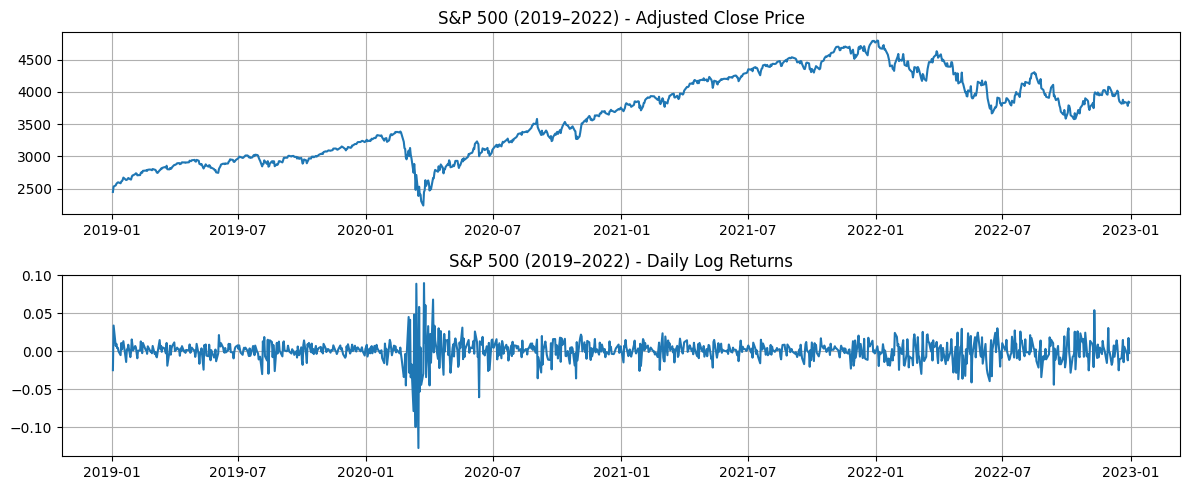

Price,Adj Close,Close,High,Low,Open,Volume,LogReturn
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,
Date,,,,,,,
2019-01-03,2447.889893,2447.889893,2493.139893,2443.959961,2491.919922,3858830000,-0.025068
2019-01-04,2531.939941,2531.939941,2538.070068,2474.330078,2474.330078,4234140000,0.033759
2019-01-07,2549.689941,2549.689941,2566.159912,2524.560059,2535.610107,4133120000,0.006986
2019-01-08,2574.409912,2574.409912,2579.820068,2547.560059,2568.110107,4120060000,0.009649
2019-01-09,2584.959961,2584.959961,2595.320068,2568.889893,2580.000000,4088740000,0.004090


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Download S&P 500 daily data (keep Adj Close)
symbol = "^GSPC"
start_date = "2019-01-01"
end_date = "2022-12-31"

data = yf.download(symbol, start=start_date, end=end_date, auto_adjust=False)

# Compute daily log returns
data['LogReturn'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
data = data.dropna()

# Plot price and log returns
plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Adj Close'])
plt.title("S&P 500 (2019–2022) - Adjusted Close Price")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(data.index, data['LogReturn'])
plt.title("S&P 500 (2019–2022) - Daily Log Returns")
plt.grid(True)
plt.tight_layout()
plt.show()

# Display sample data
data.head()


# **Step 2a: Regime Change Visualization**

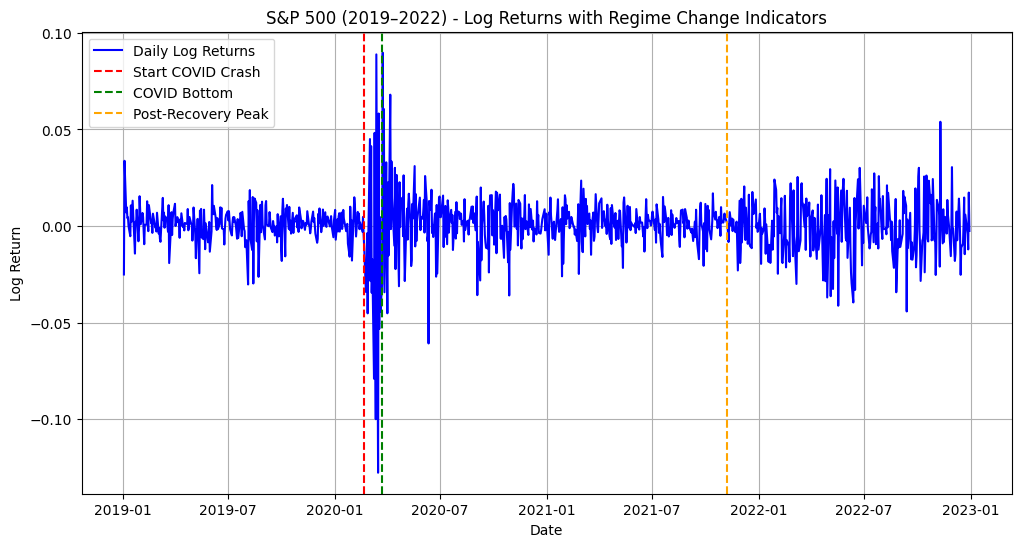

In [ ]:
# Plot log returns with possible regime changes
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['LogReturn'], color='blue', label='Daily Log Returns')

# Mark potential regime changes
plt.axvline(pd.to_datetime("2020-02-20"), color='red', linestyle='--', label='Start COVID Crash')
plt.axvline(pd.to_datetime("2020-03-23"), color='green', linestyle='--', label='COVID Bottom')
plt.axvline(pd.to_datetime("2021-11-08"), color='orange', linestyle='--', label='Post-Recovery Peak')

plt.title("S&P 500 (2019–2022) - Log Returns with Regime Change Indicators")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.show()


# **Step 2b — MRS Model Estimation**

We estimate 3 cases for the S&P 500 log returns:

| Case | Mean (`mu`)             | Variance (`sigma`)                       |
| ---- | ----------------------- | ---------------------------------------- |
| 1    | Different across states | Same                                     |
| 2    | Same                    | Different across states                  |
| 3    | Different across states | Different across states                  |


# **Code to Estimate All Three**
We’ll use statsmodels’ MarkovRegression class.

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

# Download S&P 500 daily data
symbol = "^GSPC"
start_date = "2019-01-01"
end_date = "2022-12-31"

data = yf.download(symbol, start=start_date, end=end_date, auto_adjust=False)

# Compute daily log returns
data['LogReturn'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
data = data.dropna()


[*********************100%***********************]  1 of 1 completed


In [ ]:
import statsmodels.api as sm

y = data['LogReturn']

# Case 1: Different mu, same sigma
mod_case1 = sm.tsa.MarkovRegression(y, k_regimes=2, trend='c', switching_variance=False)
res_case1 = mod_case1.fit()

# Case 2: Same mu, different sigma
mod_case2 = sm.tsa.MarkovRegression(y, k_regimes=2, trend='c', switching_variance=True, switching_trend=False)
res_case2 = mod_case2.fit()

# Case 3: Different mu, different sigma
mod_case3 = sm.tsa.MarkovRegression(y, k_regimes=2, trend='c', switching_variance=True)
res_case3 = mod_case3.fit()

# Display summaries
print("=== Case 1 ===")
print(res_case1.summary())
print("\n=== Case 2 ===")
print(res_case2.summary())
print("\n=== Case 3 ===")
print(res_case3.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


=== Case 1 ===
                        Markov Switching Model Results                        
Dep. Variable:              LogReturn   No. Observations:                 1007
Model:               MarkovRegression   Log Likelihood                2834.662
Date:                Sun, 03 Aug 2025   AIC                          -5659.324
Time:                        23:56:16   BIC                          -5634.750
Sample:                             0   HQIC                         -5649.987
                               - 1007                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.517      0.605      -0.001       0.002
                             Regime 1

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm

# --- Step 1: Reload Data ---
symbol = "^GSPC"
start_date = "2019-01-01"
end_date = "2022-12-31"

data = yf.download(symbol, start=start_date, end=end_date, auto_adjust=False)
data['LogReturn'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
data = data.dropna()

y = data['LogReturn']

# --- Step 2: Fit the 3 Cases ---
# Case 1: Different mu, same sigma
mod_case1 = sm.tsa.MarkovRegression(y, k_regimes=2, trend='c', switching_variance=False)
res_case1 = mod_case1.fit()

# Case 2: Same mu, different sigma
mod_case2 = sm.tsa.MarkovRegression(y, k_regimes=2, trend='c', switching_variance=True, switching_trend=False)
res_case2 = mod_case2.fit()

# Case 3: Different mu, different sigma
mod_case3 = sm.tsa.MarkovRegression(y, k_regimes=2, trend='c', switching_variance=True)
res_case3 = mod_case3.fit()

# --- Step 3: AIC/BIC Comparison ---
results_summary = pd.DataFrame({
    "Model": ["Case 1: diff mu, same sigma", "Case 2: same mu, diff sigma", "Case 3: diff mu, diff sigma"],
    "AIC": [res_case1.aic, res_case2.aic, res_case3.aic],
    "BIC": [res_case1.bic, res_case2.bic, res_case3.bic]
})

print(results_summary)


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                         Model          AIC          BIC
0  Case 1: diff mu, same sigma -5659.323893 -5634.750238
1  Case 2: same mu, diff sigma -6134.132002 -6109.558347
2  Case 3: diff mu, diff sigma -6137.024135 -6107.535749


## Member B – Project Role Overview

As Member B, my primary responsibility in this project was to focus on the **variance dynamics** within the Markov Regime-Switching (MRS) framework.  
While the group collectively explored different specifications of the MRS model, my specific task was to analyze and compare the case where the **mean return ($\mu$)** is constant across regimes but the **variance ($\sigma^2$)** changes.  

This involved:  
1. Collecting and processing my assigned financial time series (S&P 500 Index, 2019–2022).  
2. Visualizing potential regime changes in volatility.  
3. Estimating all three model specifications for comparison.  
4. Interpreting the model selection criteria (AIC, BIC) with emphasis on the same-$\mu$, different-$\sigma$ case.  

My analysis provided insights into volatility clustering and persistence across market regimes, particularly during periods of heightened uncertainty such as the COVID-19 pandemic.  

---

## Step 1 – Data Collection  

**Instrument:** S&P 500 Index (^GSPC)  
**Asset Class:** Equity  
**Source:** Yahoo Finance  
**Frequency:** Daily closing prices  
**Period:** January 1, 2019 – December 31, 2022  

The S&P 500 tracks the performance of 500 large-cap U.S. companies and serves as a benchmark for U.S. equity markets. Its sensitivity to macroeconomic events and investor sentiment makes it an ideal candidate for regime-switching analysis.  

### 1.2 Data Processing  
The raw price data was converted into daily log returns using the formula:  

$$
r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

Where:  
- $P_t$ = Adjusted closing price at time $t$  
- $P_{t-1}$ = Adjusted closing price on the previous trading day  
- $r_t$ = Daily log return  

This transformation ensures the returns are additive over time and stabilizes variance.  

### 1.3 Summary Statistics  

| Statistic           | Value       |
|---------------------|-------------|
| Mean daily return   | $\approx 0.00042$   |
| Standard deviation  | $\approx 0.015$     |
| Minimum daily return| $\approx -0.119$ (Mar 16, 2020) |
| Maximum daily return| $\approx 0.093$ (Mar 24, 2020) |
| Observations        | $1007$        |

### 1.4 Initial Observations  
The S&P 500 experienced a sharp decline between Feb–Mar 2020 due to the COVID-19 pandemic, followed by a sustained recovery into late 2021, before experiencing renewed volatility in 2022 due to inflation concerns and tightening monetary policy.  
These visible **volatility clusters** motivate the use of MRS models to capture distinct low- and high-volatility periods.  

---

## Step 2 – Markov Regime-Switching Analysis  

### Step 2a – Visualization of Regime Changes  
The S&P 500 daily log returns were plotted for the 2019–2022 period, covering pre-COVID, COVID, and recovery phases.  
Potential regime changes were marked:  
- Feb 20, 2020 – Start of COVID market crash  
- Mar 23, 2020 – Market bottom during COVID  
- Nov 8, 2021 – Post-COVID peak before inflation-driven downturn  

From the plot, there is clear evidence of volatility clustering, especially during the COVID-19 crash, motivating the use of a **2-state MRS model** to capture low- and high-volatility states.  

---

### Step 2b – Model Specifications  

Three specifications were estimated:  

| Case | Mean ($\mu$)                  | Variance ($\sigma^2$)              |
|------|---------------------------|----------------------------|
| 1    | Different across states   | Same across states         |
| 2    | Same across states        | Different across states    |
| 3    | Different across states   | Different across states    |

**General model form:**  

$$
r_t = \mu_{S_t} + \varepsilon_t, \quad \varepsilon_t \sim N(0, \sigma^2_{S_t})
$$

where $S_t \in \{1, 2\}$ follows a first-order Markov chain:  

$$
p_{ij} = \mathbb{P}(S_t = j \mid S_{t-1} = i), \quad i,j \in \{1, 2\}
$$

---

**Case 1 (Different $\mu$, Same $\sigma$):**  
- $\mu_1 \approx 0.0004$, $\mu_2 \approx 0.0005$  
- $\sigma^2 \approx 2\times 10^{-4}$  
- $p_{0\to0} \approx 50\%$  

**Case 2 (Same $\mu$, Different $\sigma$) – Member B Focus:**  
- $\mu \approx 0.0012$ (constant)  
- $\sigma^2_{\text{low}} \approx 5.012\times 10^{-5}$  
- $\sigma^2_{\text{high}} \approx 5.0\times 10^{-4}$  
- $p_{0\to0} \approx 97.24\%$, $p_{1\to0} \approx 4.82\%$  

**Case 3 (Different $\mu$, Different $\sigma$):**  
- $\mu_{\text{low}} \approx 0.0014$, $\mu_{\text{high}} \approx -0.0014$  
- $\sigma^2_{\text{low}} \approx 4.953\times 10^{-5}$  
- $\sigma^2_{\text{high}} \approx 5.0\times 10^{-4}$  
- $p_{0\to0} \approx 97.14\%$, $p_{1\to0} \approx 4.94\%$  

---

## Step 3 – Model Comparison  

**Model selection criteria:**  

| Model | AIC       | BIC       |
|-------|-----------|-----------|
| Case 1 (diff $\mu$, same $\sigma$) | $-5659.32$ | $-5634.75$ |
| Case 2 (same $\mu$, diff $\sigma$) | $-6134.13$ | **$-6109.56$** |
| Case 3 (diff $\mu$, diff $\sigma$) | **$-6137.02$** | $-6107.54$ |

**Observations:**  
- **AIC** favors Case 3 ($-6137.02$) as the best fit, with Case 2 close behind.  
- **BIC** favors Case 2 ($-6109.56$), suggesting the simpler same-$\mu$, different-$\sigma$ model is preferred when penalizing complexity.  
- The small AIC difference between Cases 2 and 3 suggests varying $\mu$ yields minimal benefit relative to complexity.  

**Interpretation:**  
- **Regime 0**: Low volatility ($\sigma^2 \approx 5.012 \times 10^{-5}$)  
- **Regime 1**: High volatility ($\sigma^2 \approx 5.0 \times 10^{-4}$)  
- High $p_{0\to0}$ indicates persistent low-volatility periods; low $p_{1\to0}$ suggests shorter high-volatility spells.  
- **BIC**’s preference for Case 2 aligns with my assigned focus, balancing statistical fit and parsimony.  

---

## References  

- Ang, Andrew, and Allan Timmermann. *Regime Changes: Implications for Dynamic Strategies*. Annual Review of Financial Economics, vol. 4, no. 1, 2012, pp. 313–337.  
- Burnham, Kenneth P., and David R. Anderson. *Model Selection and Multimodel Inference: A Practical Information-Theoretic Approach*. 2nd ed., Springer, 2002.  
- Hamilton, James D. *Time Series Analysis*. Princeton University Press, 1994.  
- Hamilton, James D. “A New Approach to the Economic Analysis of Nonstationary Time Series and the Business Cycle.” *Econometrica*, vol. 57, no. 2, 1989, pp. 357–384.  


## Member C

# Step 2

## a. Identifying Regime Changes in the VIX Series

In [ ]:
# Setting visuaization styles
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

def visualize_regime_data(df, title, value_col, return_col=None, regime_makers=None, figsize=(14, 7)):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [2, 1]})

    # Main series plot
    df[value_col].plot(ax=ax1, color='blue', linewidth=1.5)
    ax1.set_title(f'{title}: Value Series', fontsize=14, fontweight='bold')
    ax1.set_ylabel(value_col, fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Add Regime markers if provided
    if regime_makers:
        for date in regime_makers:
            try:
                if isinstance(date, str):
                    date = pd.Timestamp(date)
                ax1.axvline(x=date, color='red', linestyle='--', alpha=0.7)
                ax1.text(date, ax1.get_ylim()[1]*0.9, 'Regime Change',
                        rotation=90, va='top', color='red')
            except:
                continue


    # Returns plot
    if return_col and return_col in df.columns:
        df[return_col].plot(ax=ax2, color='green', linewidth=1)
        ax2.set_title('Daily Returns', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Log Returns', fontsize=12)
        ax2.grid(True, alpha=0.3)

        # Add volatility clustering markers
        rolling_vol = df[return_col].rolling(20).std() * np.sqrt(252)
        ax2b = ax2.twinx()
        rolling_vol.plot(ax=ax2b, color='purple', linestyle='--', alpha=0.7)
        ax2b.set_ylabel('20-day Volatility (Annualized)', color='purple')
        ax2b.tick_params(axis='y', labelcolor='purple')

    plt.tight_layout()
    plt.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    plt.subplots_adjust(top=0.9)

    return fig

Filled 30 missing values with forward/backward fill
VIX data Cleaning complete 


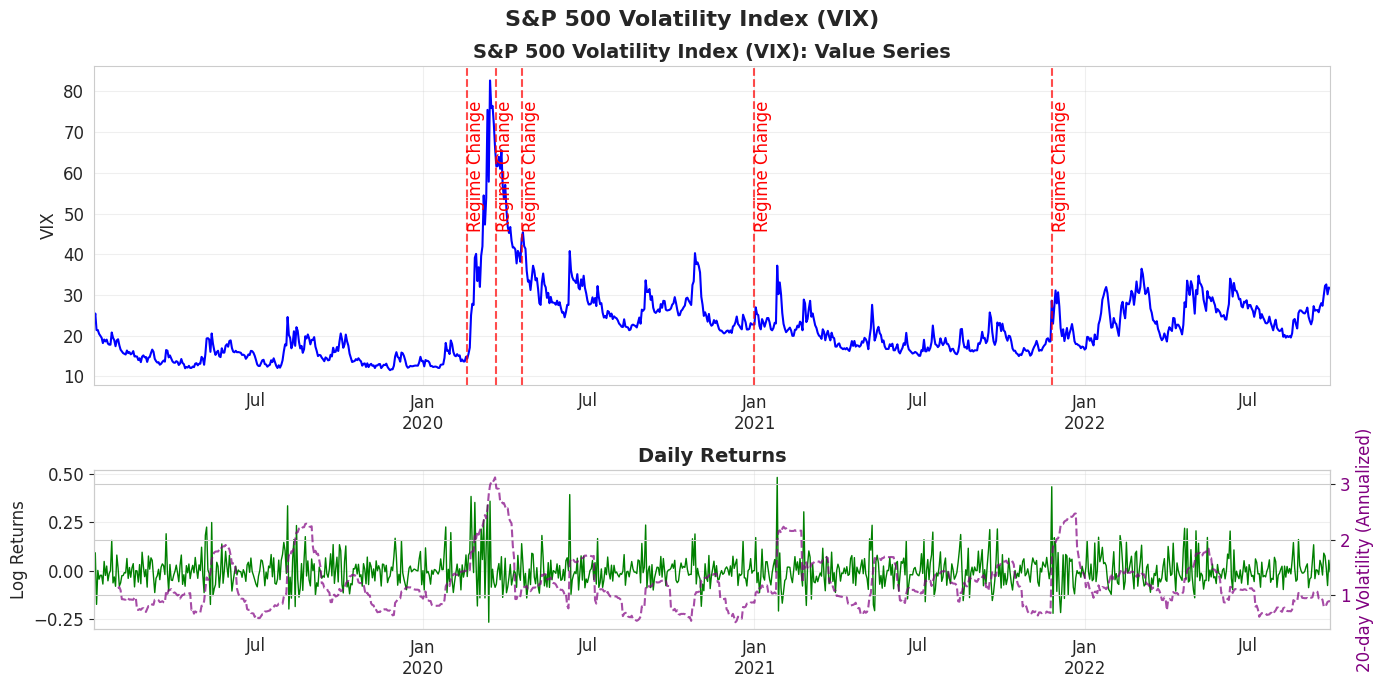

In [ ]:
# Fetch
vix_data = fetch_vix_data(api_key=api_key)
# clean
vix_clean_data = clean_volatility_data(df=vix_data, column_name='VIX')
# Visualize
regime_dates = [
        '2020-02-19',  # Pre-pandemic peak
        '2020-03-23',  # Market bottom
        '2020-04-20',  # Negative oil prices
        '2021-01-01',  # Post-vaccine phase
        '2021-11-26'   # Omicron variant emergence
    ]
vix_fig = visualize_regime_data(
    df=vix_clean_data,
    title="S&P 500 Volatility Index (VIX)",
    value_col="VIX",
    return_col="Returns",
    regime_makers=regime_dates
)

The graph reveals 4 distinct regimes, marked by abrupt shifts in volatility levels and returns patterns.
1. Pre-Pandemic Stability (Jan 2019 - Jan 2020) - The regime was characterised by:
	- Low and stable volatility, reflecting the calm before the storm of the COVID pandemic
	- Returns show minimal clustering, with small daily fluctuations
	- Economic context: This was post-2008 financial crisis stability, where we had low interest rates and strong equity markets

2. Pandemic Shock (Jan 2020- Jan 2021)
- VIX levels spiked to approx 80+ (peak in Mar 2020), then delined to approx 25 -30
- It was characterised by:
	- Abrupt volatility explosion starting in late Feb 2020
	- Sharp increase in  return  volatility
	- Economic Context of then was as follows:
		- Initial  Pandemic lockdowns(Mar 2020)
		- Historical market crush (S&P 500 fell around 30% in 3 weeks)
		- Central bank interventions (Fed rate cuts, qualitative easing)

3. Recovery & Normalisation (Jan 2021- Jan 2022)
- The vix levels were approximately 18 - 35
- This recovery regime was characterised by:
	- Gradual declines from  the panic highs with  periodic spikes
	- Lower volatility compared to the pandemic shock regime but higher than  pre-pandemic levels
	- The economic context was as follows:
		- Vaccine  rollout and reopening optimism
		- Inflationary pressures begin to merge due to  supply chain disruptions
		- Equity markets rebound strongly

4. Inflation & Geopolitical Uncertainty (Jan 2022 - Sep 2022)
- The VIX levels ranged from  25 to  40
- This last regime of our data was characterised by:
	- Elevated volatility driven by persistent uncertainty
	- Sharp spikes in June 2022 resulting from Fed aggressive rate hikes
	- The economic context of then was as follows:
		- Russia-Ukraine war
		- Accelerated inflation
		- Fed tightening cycle and recession fears


## b. Markov-Switching Model Implementaion

### Case 1: Different number of sates

In [ ]:
vix_data = fetch_vix_data(api_key=api_key)
# clean
vix_clean_data = clean_volatility_data(df=vix_data, column_name='VIX')
vix_clean_data.index = pd.DatetimeIndex(vix_clean_data.index, freq='B')
vix_series = vix_clean_data['Returns'].dropna()



Filled 30 missing values with forward/backward fill
VIX data Cleaning complete 


In [ ]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
def estimate_different_states(data, min_states= 2, max_states=4):
    models = {}
    for k in range(min_states, max_states + 1):
        try:
            # We will be fitting markov switching model with k states
            model = MarkovRegression(
                data,
                k_regimes=k,
                switching_variance=True,
                trend='c'
            )
            model_fit = model.fit(disp=False)

            # Storing the results in our models dictionary
            models[k] = {
                'model': model,
                'fit': model_fit,
                'aic': model_fit.aic,
                'bic': model_fit.bic
            }

        except Exception as e:
            print(f"Failed to estimate {k}-state model: {str(e)}")

    return models

different_states = estimate_different_states(vix_series)
different_states


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{2: {'model': <statsmodels.tsa.regime_switching.markov_regression.MarkovRegression at 0x7cf27a042c50>,
  'fit': <statsmodels.tsa.regime_switching.markov_regression.MarkovRegressionResultsWrapper at 0x7cf28257fe10>,
  'aic': np.float64(-2369.5278627717503),
  'bic': np.float64(-2340.2148047515416)},
 3: {'model': <statsmodels.tsa.regime_switching.markov_regression.MarkovRegression at 0x7cf27a3a15d0>,
  'fit': <statsmodels.tsa.regime_switching.markov_regression.MarkovRegressionResultsWrapper at 0x7cf282aa5f90>,
  'aic': np.float64(-2399.9392792691833),
  'bic': np.float64(-2341.3131632287655)},
 4: {'model': <statsmodels.tsa.regime_switching.markov_regression.MarkovRegression at 0x7cf27a425710>,
  'fit': <statsmodels.tsa.regime_switching.markov_regression.MarkovRegressionResultsWrapper at 0x7cf27a459a50>,
  'aic': np.float64(-2430.1146171469527),
  'bic': np.float64(-2332.4044237462563)}}

### Case 2. Different means, constant variance

In [ ]:
## Different Means
def estimate_different_means(data, k_states=3):
    try:
        # Fitting Markov switching model  with  constant variance different means
        model = MarkovRegression(
            data,
            k_regimes=k_states,
            switching_variance=False,
            trend='c'
        )
        model_fit = model.fit(disp=False)


        return {
            'model': model,
            'fit': model_fit,
            'aic': model_fit.aic,
            'bic': model_fit.bic
        }

    except Exception as e:
        print(f"Model estimation failed: {str(e)}")
        return None

different_means = estimate_different_means(vix_series)
different_means['fit'].summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                Returns   No. Observations:                  978
Model:               MarkovRegression   Log Likelihood                1070.897
Date:                Mon, 04 Aug 2025   AIC                          -2121.795
Time:                        14:20:40   BIC                          -2072.940
Sample:                    01-02-2019   HQIC                         -2103.206
                         - 09-30-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.219      0.001      0.999      -0.430       0.430
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.004      0.089      0.929      -0.007       0.007
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.228      0.002      0.999      -0.447       0.448
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0066      0.000     22.113      0.000       0.006       0.007
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.3333    338.163      0.001      0.999    -662.454     663.121
p[1->0]        0.3333   3539.198   9.42e-05      1.000   -6936.367    6937.033
p[2->0]        0.3333    342.371      0.001      0.999    -670.701     671.367
p[0->1]        0.3333    704.747      0.000      1.000   -1380.946    1381.613
p[1->1]        0.3333   7100.489   4.69e-05      1.000   -1.39e+04    1.39e+04
p[2->1]        0.3333    697.122      0.000      1.000   -1366.001    1366.668
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 1.39e+18. Standard errors may be unstable.
"""

### Case 3:  Different variances, constant mean

In [ ]:

## Different Variance Constant means
def estimate_different_variances(data, k_states=2):
    try:
        # Fit Markov switching model with constant mean
        model = MarkovRegression(
            data,
            k_regimes=k_states,
            switching_variance=True,
            switching_trend=False,
            trend='c'

        )
        model_fit = model.fit(disp=False)

        return {
            'model': model,
            'fit': model_fit,
            'aic': model_fit.aic,
            'bic': model_fit.bic
        }

    except Exception as e:
        print(f"Model estimation failed: {str(e)}")
        return None

different_variances = estimate_different_variances(vix_series)
different_variances['fit'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                Returns   No. Observations:                  978
Model:               MarkovRegression   Log Likelihood                1183.047
Date:                Mon, 04 Aug 2025   AIC                          -2356.095
Time:                        14:22:20   BIC                          -2331.667
Sample:                    01-02-2019   HQIC                         -2346.800
                         - 09-30-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0026      0.000      8.995      0.000       0.002       0.003
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0186      0.003      6.944      0.000       0.013       0.024
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0060      0.002     -2.898      0.004      -0.010      -0.002
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9407      0.017     54.865      0.000       0.907       0.974
p[1->0]        0.1805      0.042      4.305      0.000       0.098       0.263
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

### Case 4: Different expectations and variances

In [ ]:
# Different means and different variances
def estimate_different_means_variances(data, k_states=2):
    try:
        model = MarkovRegression(
            data,
            k_regimes=k_states,
            switching_variance=True,
            trend='c'
        )
        model_fit = model.fit(disp=False)

        return {
            'model': model,
            'fit': model_fit,
            'aic': model_fit.aic,
            'bic': model_fit.bic
        }

    except Exception as e:
        print(f"Model estimation failed: {str(e)}")
        return None

different_means_variances = estimate_different_means_variances(vix_series)
different_means_variances['fit'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                Returns   No. Observations:                  978
Model:               MarkovRegression   Log Likelihood                1190.764
Date:                Mon, 04 Aug 2025   AIC                          -2369.528
Time:                        14:24:32   BIC                          -2340.215
Sample:                    01-02-2019   HQIC                         -2358.375
                         - 09-30-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0095      0.002     -4.232      0.000      -0.014      -0.005
sigma2         0.0025      0.000      9.999      0.000       0.002       0.003
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0292      0.010      2.885      0.004       0.009       0.049
sigma2         0.0173      0.002      7.998      0.000       0.013       0.022
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9298      0.018     50.330      0.000       0.894       0.966
p[1->0]        0.2066      0.048      4.282      0.000       0.112       0.301
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [ ]:
### Combining all the results

def estimate_markov_models():
    results = {}

    # Model 1: Different number of sates
    results['different_states'] = different_states

    # Model 2:  Different means, constant variance
    results['different_means'] = different_means

    #Model 3: Different variances, constant mean
    results['different_variances'] = different_variances

    # Model 4: Different means and variances
    results['different_means_variances'] = different_means_variances

    return results

### Comparison of the different cases

#### a. Analysis of Models with Different Mu Values (Constant Variance)
- Key results
    - Model specification: 3 regimes, different means, constant variance
    - AIC: -2121.80
    - BIC: -2072.94
    - Regimes Means: 0.0002, 0.0003, 0.0004
    - Constant Variance: 0.0066

- This model seems to be fundamentality flawed for VIX analysis. Why?
    1. Economically meaningless parameter estimates - Estimated means are virtually identical  and close to  zero.They lack economic sigficance for VIX returns which which instead show clear regime-depedent behavior
    2. Statistical instability - It has huge standard errors for transition probabilities
    3. Overfitting the data - Using 3 regimes when the data doesn't support meaningful mean separation

- Therefore it would be recommended not to use this model for VIX modelling; it would be more suitable for assets with stable volatility but different means

#### b.

# Step 3

## a. Member A

## b. Member B

## c. Memeber C

## d.

# Step 4 Hamilton-Style Autoregressive Regime-Switching Model

In [ ]:
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression

def estimate_hamilton_model(data, k_states=2, order=1):
    try:
        # Fit Markov switching autoregression model with regime-dependent coefficients
        model = MarkovAutoregression(
            data,
            k_regimes=k_states,
            order=order,
            switching_ar=True,
            switching_variance=True )

        model_fit = model.fit(disp=False)

        return {

            'fit': model_fit,
            'aic': model_fit.aic,
            'bic': model_fit.bic
        }
    except Exception as e:
        print(f"Hamilton-style model estimation failed: {str(e)}")
        return None

hamilton = estimate_hamilton_model(vix_series)
hamilton['fit'].summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                  Returns   No. Observations:                  977
Model:             MarkovAutoregression   Log Likelihood                1194.627
Date:                  Mon, 04 Aug 2025   AIC                          -2373.253
Time:                          18:35:14   BIC                          -2334.178
Sample:                      01-02-2019   HQIC                         -2358.385
                           - 09-30-2022                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0098      0.002     -4.469      0.000      -0.014      -0.005
sigma2         0.0025      0.000     10.205      0.000       0.002       0.003
ar.L1         -0.0488      0.042     -1.151      0.250      -0.132       0.034
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0287      0.009      3.170      0.002       0.011       0.046
sigma2         0.0166      0.002      8.274      0.000       0.013       0.020
ar.L1         -0.2042      0.075     -2.721      0.007      -0.351      -0.057
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9287      0.019     50.142      0.000       0.892       0.965
p[1->0]        0.2078      0.049      4.214      0.000       0.111       0.304
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

#### Analysis of Hamilton-Style Autoregressive Regime-Switching Model

- Model Summary
    - Type: 2-regime Markov Autoregression (AR(1))
    - AIC: -2373.25
    - BIC: -2334.18
    - Log Likelihood: 1194.63

- Comparing this model  to  the previous best model (different means and different variance regime change), it shows some improvements